# SRC physics

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ April 9, 2021

Generates SRC physics figures based on this paper: A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __104__, 034311 (2021)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.104.034311).

_Last update:_ July 29, 2022

In [1]:
# Python imports
from itertools import chain
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, line_styles, xkcd_colors, label_kvnn, label_lambda,
    label_nucleus
)
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_matrix,
    unattach_weights_from_vector
)
from scripts.lda_momentum_distributions import MomentumDistribution
from scripts.momentum_projection_operator import momentum_projection_operator
from scripts.potentials import Potential
from scripts.src_scaling_factor import compute_a2
from scripts.srg import get_transformation
from scripts.tools import find_index, replace_periods
from scripts.wave_function import wave_function

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/src/'

# Directory for VMC data
vmc_directory = '../data/vmc/momentum_distributions'

# Directory for experimental a_2 values
exp_directory = '../data/exp'

## Plotting functions

In [5]:
def srg_transformation_ratio(
        k_0, kvnns, lamb, kmax=15.0, kmid=3.0, ntot=120, x_limits=(0,4),
        y_limits=(1e0,1e3), xlabel_size=16, ylabel_size=16, ratio_label=True,
        save=False):
    """
    Plots the ratio of |U(k_0,q)_{3S1-3D1}|^2 / |U(k_0,q)_{1S0}|^2 where
    k_0 < \lambda.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0,q)_{3S1} / U(k_0,q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers that specify a set of potentials.
    lamb : float
        SRG evolution parameter \lambda [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    ratio_label : bool, optional
        Option to label the ratio 3S1/1S0 on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Store |U(k_0, q)|^2 in dictionary with channel as key
        d = {}
        
        # Loop over 3S1 and 1S0:
        for channel in ('3S1', '1S0'):
            
            # Initialize potential object and get its momentum mesh
            potential = Potential(kvnn, channel, kmax, kmid, ntot)
            q_array, q_weights = potential.load_mesh()
            
            # Get index of k_0 in k_array
            k0_index = find_index(k_0, q_array)
        
            # Get initial and evolved Hamiltonians [MeV]
            H_initial = potential.load_hamiltonian()
            H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
            # Calculate unitary transformation [unitless]
            U_matrix_weights = get_transformation(H_initial, H_evolved)
        
            # Divide out integration weights [fm^3] and add to dictionary
            d[channel] = unattach_weights_from_matrix(
                q_array, q_weights, U_matrix_weights,
                coupled_channel=potential.coupled_channel_bool
            )
            
        # Calculate |U(k_0, q)_{3S1}|^2
        numerator_array = (
            d['3S1'][k0_index, :ntot]*d['3S1'].T[:ntot, k0_index]
            + d['3S1'][k0_index, ntot:]*d['3S1'].T[ntot:, k0_index]
        )
        
        # Calculate |U(k_0, q)_{1S0}|^2
        denominator_array = (d['1S0'][k0_index, :ntot]
                             * d['1S0'].T[:ntot, k0_index])
        
        # Take ratio of 3S1 / 1S0
        ratio_array = numerator_array / denominator_array
            
        # --- Set data labels --- #
        curve_color = xkcd_colors(i+1)  # Skip xkcd:black
        curve_label = label_kvnn(kvnn)  # Labels the potential
        
        # --- Plot --- #
        ax.semilogy(q_array, ratio_array, color=curve_color,
                    label=curve_label, linestyle='solid', linewidth=2.0)

    # --- Plot final features --- #
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.2, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$|U_{\lambda}(k_0,q)|^2$" + ' ratio',
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='lower left', fontsize=13, frameon=True)
    
    # --- Additional labels --- #
    if ratio_label:  # Label 3S1/1S0
        ax.add_artist(
            AnchoredText(r'$\frac{^3{\rm S}_1}{^{1}{\rm S}_0}$',
                         loc='upper right', prop=dict(size=24), frameon=False)
        )

    # --- Save file --- #
    if save:
        file_name = f'srg_transformation_ratio_k_0_{k_0}_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [6]:
def interleave(*iters):
    """
    Take a set of lists of the same length and interleave them.
    """
    return list(chain(*zip(*iters)))

In [7]:
def deuteron_partial_wave_contributions(
        kvnns, lamb, q_values, kmax, kmid, ntot):
    """
    Calculates the partial wave contributions to |\psi_d(q)|^2 at several q
    values for a couple of potentials. Use this function with the bar chart
    function below.
    """
    
    # Store results in dictionary with kvnn, q, and partial waves as keys
    d = {}
    
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Store results in arrays like q_values
        d[kvnn]['Initial 3S1-3S1'] = np.zeros_like(q_values)
        d[kvnn]['Initial 3S1-3D1'] = np.zeros_like(q_values)
        d[kvnn]['Initial 3D1-3D1'] = np.zeros_like(q_values)
        d[kvnn]['Evolved 3S1-3S1'] = np.zeros_like(q_values)
        d[kvnn]['Evolved 3S1-3D1'] = np.zeros_like(q_values)
        d[kvnn]['Evolved 3D1-3D1'] = np.zeros_like(q_values)
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        q_array, q_weights = potential.load_mesh()

        # Get initial and evolved Hamiltonians [MeV]
        H_initial = potential.load_hamiltonian()
        H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
        # Calculate unitary transformation [unitless]
        U_matrix = get_transformation(H_initial, H_evolved)

        # Get initial and evolved wave functions [unitless]
        psi_initial = wave_function(H_initial)
        psi_evolved = wave_function(H_initial, U_matrix=U_matrix)

        # Loop over q values and calculate evolved momentum projection
        # operator at each q, then calculate contributions to |\psi_d(q)|^2
        for i, q in enumerate(q_values):

            # Compute the initial and evolved momentum projection operators in
            # units [fm^3]
            mpo_operator_initial = momentum_projection_operator(
                q, q_array, q_weights, coupled=True, smeared=False
            )
            mpo_operator_evolved = momentum_projection_operator(
                q, q_array, q_weights, coupled=True, U_matrix=U_matrix,
                smeared=False
            )

            # Each contribution to |\psi_d(q)|^2 for initial with total
            psi2_3S1_3S1_initial = abs(
                psi_initial.T[:ntot] @ mpo_operator_initial[:ntot, :ntot] 
                @ psi_initial[:ntot]
            )
            psi2_3S1_3D1_initial = abs(
                psi_initial.T[:ntot] @ mpo_operator_initial[:ntot, ntot:]
                @ psi_initial[ntot:]
            )
            psi2_3D1_3S1_initial = abs(
                psi_initial.T[ntot:] @ mpo_operator_initial[ntot:, :ntot] 
                @ psi_initial[:ntot]
            )
            psi2_3D1_3D1_initial = abs(
                psi_initial.T[ntot:] @ mpo_operator_initial[ntot:, ntot:]
                @ psi_initial[ntot:]
            )
            psi2_initial = (psi2_3S1_3S1_initial + psi2_3S1_3D1_initial
                            + psi2_3D1_3S1_initial + psi2_3D1_3D1_initial)

            # Each contribution to |\psi_d(q)|^2 for evolved with total
            psi2_3S1_3S1_evolved = abs(
                psi_evolved.T[:ntot] @ mpo_operator_evolved[:ntot, :ntot]
                @ psi_evolved[:ntot]
            )
            psi2_3S1_3D1_evolved = abs(
                psi_evolved.T[:ntot] @ mpo_operator_evolved[:ntot, ntot:] 
                @ psi_evolved[ntot:]
            )
            psi2_3D1_3S1_evolved = abs(
                psi_evolved.T[ntot:] @ mpo_operator_evolved[ntot:, :ntot]
                @ psi_evolved[:ntot]
            )
            psi2_3D1_3D1_evolved = abs(
                psi_evolved.T[ntot:] @ mpo_operator_evolved[ntot:, ntot:]
                @ psi_evolved[ntot:]
            )
            psi2_evolved = (psi2_3S1_3S1_evolved + psi2_3S1_3D1_evolved
                            + psi2_3D1_3S1_evolved + psi2_3D1_3D1_evolved)
        
            # Calculate the percentage of each contribution
            d[kvnn]['Initial 3S1-3S1'][i] = (psi2_3S1_3S1_initial
                                             / psi2_initial * 100)
            # Factor of 2 for 3D1-3S1
            d[kvnn]['Initial 3S1-3D1'][i] = (2 * psi2_3S1_3D1_initial
                                             / psi2_initial * 100)
            d[kvnn]['Initial 3D1-3D1'][i] = (psi2_3D1_3D1_initial
                                             / psi2_initial * 100)
            d[kvnn]['Evolved 3S1-3S1'][i] = (psi2_3S1_3S1_evolved
                                             / psi2_evolved * 100)
            # Factor of 2 for 3D1-3S1
            d[kvnn]['Evolved 3S1-3D1'][i] = (2 * psi2_3S1_3D1_evolved
                                             / psi2_evolved * 100)
            d[kvnn]['Evolved 3D1-3D1'][i] = (psi2_3D1_3D1_evolved
                                             / psi2_evolved * 100)
            
    # Merge the results into arrays for 3S1-3S1, 3S1-3D1, and 3D1-3D1
    blank = np.zeros_like(q_values)
    SS_merge = interleave(
        d[kvnns[0]]['Initial 3S1-3S1'], d[kvnns[1]]['Initial 3S1-3S1'], blank,
        d[kvnns[0]]['Evolved 3S1-3S1'], d[kvnns[1]]['Evolved 3S1-3S1'], blank
    )
    SD_merge = interleave(
        d[kvnns[0]]['Initial 3S1-3D1'], d[kvnns[1]]['Initial 3S1-3D1'], blank,
        d[kvnns[0]]['Evolved 3S1-3D1'], d[kvnns[1]]['Evolved 3S1-3D1'], blank
    )
    DD_merge = interleave(
        d[kvnns[0]]['Initial 3D1-3D1'], d[kvnns[1]]['Initial 3D1-3D1'], blank,
        d[kvnns[0]]['Evolved 3D1-3D1'], d[kvnns[1]]['Evolved 3D1-3D1'], blank
    )

    return SS_merge, SD_merge, DD_merge

In [8]:
def deuteron_percentage_bar_chart(
        kvnns, lamb, q_values, kmax=15.0, kmid=3.0, ntot=120, x_labels=None,
        title=None):
    """
    Make a bar chart with percentages of deuteron partial wave contributions
    to |\psi_d(q)|^2.
    """
    
    SS_merge, SD_merge, DD_merge = deuteron_partial_wave_contributions(
        kvnns, lamb, q_values, kmax, kmid, ntot
    )
    
    DD_bottom = np.array(SS_merge) + np.array(SD_merge)
    
    ind = np.arange(len(SS_merge))/2. # the x locations for the groups

    f = plt.figure(figsize=(4,3))
    ax = f.add_subplot(1,1,1)

    width = 0.5

    ax.bar(ind, SS_merge, width, color='red', edgecolor='xkcd:black',
           label=r'$^3{\rm S}_1-^3{\rm S}_1$')
    ax.bar(ind, SD_merge, width, bottom=SS_merge, color='blue',
           edgecolor='xkcd:black', label=r'$^3{\rm S}_1-^3{\rm D}_1$')
    ax.bar(ind, DD_merge, width, bottom=DD_bottom, color='green',
           edgecolor='xkcd:black', label=r'$^3{\rm D}_1-^3{\rm D}_1$')
    
    ax.text(1, 105, fr'$q = {q_values[0]}\,{{\rm fm}}^{{-1}}$', ha='center',
            fontsize=11)
    ax.text(4, 105, fr'$q = {q_values[1]}\,{{\rm fm}}^{{-1}}$', ha='center',
            fontsize=11)
    ax.text(7, 105, fr'$q = {q_values[2]}\,{{\rm fm}}^{{-1}}$', ha='center',
            fontsize=11)
    
    x_label_size = 14
    y_label_size = 14
    
    ax.set_title(title)
    ax.set_ylabel('percentage', fontsize=y_label_size)
    ax.set_xlabel(r'$\lambda\ [{\rm fm}^{-1}]$', fontsize=x_label_size)
    ind2 = np.arange(0.25, 8.25, 1.5)
    ax.set_xticks(ind2)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlim( ind[0]-0.5, ind[-1])
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_ylim(0, 120)

    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=3,
              mode="expand", borderaxespad=0., fontsize=9)
    
    # Save figure
    fig_file = 'AV18_Gezerlis_percentages_deuteron_band' + '.png'
    f.savefig(figures_directory + fig_file)

In [9]:
def deuteron_momentum_distribution_contributions(
        kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120, number_of_curves=4,
        x_limits=(0, 4), y_limits=(1e-5, 1e3), xlabel_size=16, ylabel_size=16,
        save=False):
    """
    Plots the SRG-evolved deuteron pair momentum distribution as calculated
    by our expansion of U(k, k') in second quantization using deuteron wave
    function (not LDA). This function shows each of the contributions from 1,
    \delta U, \delta U \delta U^\dagger terms.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG evolution parameter \lambda [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    number_of_curves : int, optional
        Number of curves to be plotted starting with the full unevolved
        result, then the 1 term, \delta U, term, and finally \delta U^2 term.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm^3].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # Make sure the number of curves makes sense (1 to 4)
    if not (number_of_curves in range(1, 5)):
        raise RuntimeError(
            'Invalid number of curves. Must specify an integer from 1 to 4.'
        )
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'

    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Get initial and evolved Hamiltonians [MeV]
    H_initial = potential.load_hamiltonian()
    H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
    # Calculate unitary transformation [unitless]
    U_matrix = get_transformation(H_initial, H_evolved)
    
    # Isolate the two-body piece \delta U [unitless]
    I_matrix = np.eye(2*ntot, 2*ntot)
    delta_U_matrix = U_matrix - I_matrix
    
    # Get deuteron wave functions [unitless]
    psi_d_initial_weights = wave_function(H_initial, eps=-2.22)
    psi_d_evolved_weights = wave_function(H_initial, eps=-2.22,
                                          U_matrix=U_matrix)
    
    # High resolution momentum distribution [fm^3]
    psi_d_initial = unattach_weights_from_vector(
        q_array, q_weights, psi_d_initial_weights, coupled_channel=True
    )
    n_d_total_array = psi_d_initial[:ntot]**2 + psi_d_initial[ntot:]**2
    
    # Initialize contributions to the deuteron momentum distribution
    n_d_1_array = np.zeros_like(q_array)
    n_d_deltaU_array = np.zeros_like(q_array)
    n_d_deltaU2_array = np.zeros_like(q_array)
    
    # Loop over momenta and calculate evolved momentum projection operator
    # at each q, then calculate contributions to |\psi_d(q)|^2
    for i, q in enumerate(q_array):
        
        # Compute the momentum projection operator [fm^3]
        mpo_operator = momentum_projection_operator(
            q, q_array, q_weights, coupled=True, smeared=False
        )

        # Term 1: 1 * n(q) * 1
        n_d_1_array[i] = (psi_d_evolved_weights.T @ mpo_operator
                          @ psi_d_evolved_weights)
        
        # Term 2: \deltaU * n(q) * 1 (multiply by 2 since Term 3 = Term 2)
        n_d_deltaU_array[i] = 2 * (psi_d_evolved_weights.T @ delta_U_matrix
                                   @ mpo_operator @ psi_d_evolved_weights)
        
        # High-q term: \deltaU * n(q) * \deltaU^\dagger
        n_d_deltaU2_array[i] = (
            psi_d_evolved_weights.T @ delta_U_matrix @ mpo_operator
            @ delta_U_matrix.T @ psi_d_evolved_weights
        )
    
    # --- Plot --- #
    # Total deuteron wave function (high resolution)
    ax.semilogy(q_array, n_d_total_array, color='xkcd:black',
                label="High res.", linestyle='solid', linewidth=2.0)
    
    # Plot 1 term
    if number_of_curves > 1:
        ax.semilogy(q_array, n_d_1_array, color='xkcd:blue', label="1",
                    linestyle='dotted', linewidth=2.0)
        
    # Plot \delta U term (take absolute value!)
    if number_of_curves > 2:
        ax.semilogy(q_array, abs(n_d_deltaU_array), color='xkcd:green',
                    label=r"$|\delta U|$", linestyle='dashed', linewidth=2.0)
        
    # Plot \delta U^2 term
    if number_of_curves > 3:
        ax.semilogy(
            q_array, n_d_deltaU2_array, color='xkcd:red',
            label=r'$\delta U \delta U^{\dagger}$', linestyle='dashdot',
            linewidth=2.0
        )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^d(q)$" + " [fm" + r"$^3$" + "]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=14, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = ('deuteron_momentum_distribution_contributions_kvnn_'
                     f'{kvnn}_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
                     f'_number_of_curves_{number_of_curves}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [10]:
def delU_factorization_ratios(
        k_0, k_i_values, kvnn, channel, lamb, kmax=15.0, kmid=3.0, ntot=120,
        x_limits=(0, 5), y_limits=(1e-2, 1e2), xlabel_size=16, ylabel_size=16,
        k0_lamb_label=True, save=False):
    """
    Ratio of \delta U \delta U^{\dagger} with respect to momentum [fm^-1] for
    k = k_i_values in the numerator and k = k_0 in the denominator, and 
    k' = q_array in numerator and denominator.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0,q) in the denominator [fm^-1].
    k_i_values : tuple
        Momentum values for U(k_i,q) in the numerator [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lamb : float
        SRG evolution parameter \lambda [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    k0_lamb_label_label : bool, optional
        Option to label k_0 and \lambda on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Get initial and evolved Hamiltonians [MeV]
    H_initial = potential.load_hamiltonian()
    H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
    # Calculate unitary transformation [unitless]
    U_matrix_unitless = get_transformation(H_initial, H_evolved)
    
    # Isolate the two-body piece \delta U [unitless]
    if potential.coupled_channel_bool:
        I_matrix_unitless = np.eye(2*ntot, 2*ntot)
    else:
        I_matrix_unitless = np.eye(ntot, ntot)
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
    
    # Divide out integration factor
    delta_U_matrix = unattach_weights_from_matrix(
        q_array, q_weights, delta_U_matrix_unitless,
        coupled_channel=potential.coupled_channel_bool
    )
    
    # Calculate \delta U(k_0, q) \delta U^{\dagger}(q, k_0) array
    k0_index = find_index(k_0, q_array)
    # Single channel (do not include coupled parts for coupled-channel)
    denominator_array = (delta_U_matrix[k0_index, :ntot] 
                         * delta_U_matrix.T[:ntot, k0_index])
    
    # Loop over k_i
    for i, k_i in enumerate(k_i_values):
    
        # Calculate \delta U(k_i, q) \delta U^{\dagger}(q, k_i) array
        ki_index = find_index(k_i, q_array)
        # Single channel (do not include coupled parts for coupled-channel)
        numerator_array = (delta_U_matrix[ki_index, :ntot] 
                           * delta_U_matrix.T[:ntot, ki_index])
        
        # Take absolute value of ratio
        ratio_array = abs(numerator_array/denominator_array)

        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = rf'$k_{i+1}={k_i}$' + ' fm' + r'$^{-1}$'

        # --- Plot --- #
        ax.semilogy(q_array, ratio_array, color=curve_color,
                    label=curve_label, linestyle=curve_style, linewidth=2.0)

    # --- Plot final features --- #
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.3, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$\delta U \delta U^{\dagger}(k, q)$" + " ratio",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=11, frameon=False)
    
    # --- Additional labels --- #
    if k0_lamb_label:  # Label k_0 and \lambda
        k_0_label = rf'$k_0={k_0}$' + ' fm' + r'$^{-1}$'
        lambda_label = label_lambda(lamb)
        ax.add_artist(
            AnchoredText(k_0_label + '\n' + lambda_label, loc='lower right',
                         prop=dict(size=11), frameon=False)
        )

    # --- Save file --- #
    if save:
        file_name = f'delU_factorization_ratios_k0_{k_0}_ki'
        for k_i in k_i_values:
            file_name += f'_{k_i}'
        file_name += (f'_{kvnn}_{channel}_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}'
                      f'_ntot_{ntot}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [11]:
def proton_momentum_distribution(
        nucleus, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(0,6),
        y_limits=(4e-4,3e2), xlabel_size=16, ylabel_size=16,
        exclude_low_q=True, save=False):
    """
    Plots a proton momentum distribution as calculated in the LDA with SRG-
    evolution. This function compares to VMC momentum distribution data when
    possible.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple:
        (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm^3].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    exclude_low_q : bool, optional
        Option to only show the distribution at q > 0.6 fm^-1.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # --- Get data --- #
    # Unpack nucleus information
    nucleus_name, Z, N = nucleus
    
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
        'proton', nucleus_name, density, channels, generator, lamb
    )
    
    # Only show n(q) at q > 0.6 fm^-1
    if exclude_low_q:
        q_min_index = find_index(0.6, q_array)
        q_array = q_array[q_min_index:]
        n_p_array = n_p_array[q_min_index:]

    # --- Plot --- #
    ax.plot(q_array, n_p_array/Z, color='xkcd:red',
            label=label_nucleus(nucleus_name), linewidth=2.0)

    # --- Plot final features --- #
    # Add VMC data with error bars
    try:
        vmc_data = np.loadtxt(vmc_directory + '/'
                              + f'{nucleus_name}_single_nucleon.txt')
        q_array_vmc = vmc_data[:, 0] # fm^-1
        n_p_array_vmc = vmc_data[:, 1]
        error_bars_array_vmc = vmc_data[:, 2]
        ax.errorbar(q_array_vmc, n_p_array_vmc/Z, yerr=error_bars_array_vmc/Z,
                    color='xkcd:black', label='VMC', linestyle='', marker='.')
    except OSError:  # No VMC data for this nucleus
        print(f"There is no VMC data for {nucleus_name}.")
    
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.3, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=16, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = (f'proton_momentum_distribution_{nucleus_name}_kvnn'
                     f'_{kvnn}')
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [12]:
def multiple_proton_momentum_distributions(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(0,6),
        y_limits=(4e-4,3e2), xlabel_size=16, ylabel_size=16,
        exclude_low_q=True, save=False):
    """
    Plots several proton momentum distributions as calculated in the LDA with
    SRG-evolution. This function compares to VMC momentum distribution data
    when possible.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm^3].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    exclude_low_q : bool, optional
        Option to only show the distribution at q > 0.6 fm^-1.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(nuclei)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
    
        q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, channels, generator, lamb
        )
    
        # Only show n(q) at q > 0.6 fm^-1
        if exclude_low_q:
            q_min_index = find_index(0.6, q_array)
            q_array = q_array[q_min_index:]
            n_p_array = n_p_array[q_min_index:]
        
        # --- Plot --- #
        # Set y-axis to log scale
        axs[i].set_yscale('log')
        
        axs[i].plot(q_array, n_p_array/Z, color='xkcd:red',
                    label=label_nucleus(nucleus_name), linewidth=2.0)

        # --- Plot final features --- #
        # Add VMC data with error bars
        try:
            vmc_data = np.loadtxt(vmc_directory + '/'
                                  + f'{nucleus_name}_single_nucleon.txt')
            q_array_vmc = vmc_data[:, 0] # fm^-1
            n_p_array_vmc = vmc_data[:, 1]
            error_bars_array_vmc = vmc_data[:, 2]
            axs[i].errorbar(
                q_array_vmc, n_p_array_vmc/Z, yerr=error_bars_array_vmc/Z,
                color='xkcd:black', label='VMC', linestyle='', marker='.'
            )
        except OSError:  # No VMC data for this nucleus
            print(f"There is no VMC data for {nucleus_name}.")
    
        # Shade gray from 0 to \lambda value on plot
        axs[i].fill_betweenx(y_limits, 0.0, lamb, alpha=0.3,
                             edgecolor='xkcd:grey', facecolor='xkcd:grey')

        # --- Axes limits --- #
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)  

        # --- Axes labels --- #
        axs[i].set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    
    # Only label the far left y-axis
    axs[0].set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                      fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.08)
    
    # Manually set x-axis to show q in steps of 1 fm^-1
    x_ticks = np.arange(x_limits[0], x_limits[1]+1.0, 1.0)
    for i in range(col_number):
        axs[i].set_xticks(x_ticks)
    
        # --- Legend --- #
        axs[i].legend(loc='upper right', fontsize=14, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = 'proton_momentum_distributions'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [13]:
def proton_momentum_distribution_tails(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(1.5,6.0),
        y_limits=(1e-3,1e0), xlabel_size=16, ylabel_size=16, save=False):
    """
    Plots several proton momentum distributions as calculated in the LDA with
    SRG-evolution on the same plot, focusing on the high-momentum tail. This
    function is useful for examining univesality in the momentum
    distributions.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm^3].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus

        q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, channels, generator, lamb
        )
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.semilogy(q_array, n_p_array/Z, color=curve_color,
                    linestyle=curve_style, label=curve_label, linewidth=2.0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=13, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = f'proton_momentum_distribution_tails'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [14]:
def partial_wave_contributions_table(
        nuclei, kvnn, channels=('1S0','3S1', '3P0', '1P1', '3P1'), kmax=15.0,
        kmid=3.0, ntot=120, generator='Wegner', lamb=1.35, density='SLy4'):
    """
    Fraction of partial wave contributions to total normalization of the 
    high-q tail in the LDA and SRG-evolved proton momentum distributions.
    This is done by computing
        \int_2^\infty dq q^2 n_A^p(q)_X / \int_2^\infty dq q^2 n_A^p(q),
    where X is a single partial wave channel.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
        
    """
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)

    # Create momentum mesh for integration from 2-\infty fm^-1
    q_min = 2.0
    q_max = kmax  # Corresponds to \infinity
    ntot_q = 80
    q_array, q_weights = gaussian_quadrature_mesh(q_max, ntot_q, xmin=q_min)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
        print(f"\n{nucleus_name}")
        print("-"*10)
    
        # First calculate denominator with all partial waves
        n_p_func = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, channels, generator, lamb,
            interpolate=True
        )
        
        n_p_array = n_p_func(q_array)
        
        denominator = np.sum(q_weights*q_array**2*n_p_array)
        
        # Loop over channels and calculate isolated contributions
        for channel in channels:
            
            n_p_func = md.get_single_nucleon_momentum_distribution(
                'proton', nucleus_name, density, [channel], generator, lamb,
                interpolate=True
            )
            
            n_p_array = n_p_func(q_array)
        
            numerator = np.sum(q_weights*q_array**2*n_p_array)
            
            # Calculate percentage contribution
            percent = round(numerator/denominator*100, 1)

            # --- Print table --- #
            print(f"{channel}: {percent}%")

In [15]:
def proton_over_neutron_pmd_ratios(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(1.5,4),
        y_limits=(0.82,1.15), xlabel_size=16, ylabel_size=16,
        ratio_label=True, save=False):
    """
    Ratio of (pp+pn)/(nn+np) pair momentum distributions in several nuclei
    with Q=0 fm^-1.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    ratio_label : bool, optional
        Option to label the ratio (pp+pn)/(nn+np) on the figure as an
        anchored text.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
    
        # Get pp, pn, and nn pair momentum distributions at Q = 0 fm^-1
        q_array, n_pp_array = md.get_pair_momentum_distribution(
            'pp', nucleus_name, density, channels, generator, lamb,
            Q_equals_zero=True
        )
        q_array, n_pn_array = md.get_pair_momentum_distribution(
            'pn', nucleus_name, density, channels, generator, lamb,
            Q_equals_zero=True
        )
        q_array, n_nn_array = md.get_pair_momentum_distribution(
            'nn', nucleus_name, density, channels, generator, lamb,
            Q_equals_zero=True
        )
        
        # Take ratio of (pp+pn) / (nn+np) where pn=np
        ratio_array = (n_pp_array+n_pn_array) / (n_nn_array+n_pn_array)
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.plot(q_array, ratio_array, color=curve_color,
                linestyle=curve_style, label=curve_label, linewidth=2.0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^A(q,Q=0)$" + " ratio", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=12, frameon=False, ncol=2)
    
    # --- Additional labels --- #
    if ratio_label:  # Label (pp+pn)/(nn+np)
        ax.add_artist(
            AnchoredText(r'$\frac{pp+pn}{nn+np}$', loc='lower left',
                         prop=dict(size=24), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = 'proton_over_neutron_pmd_ratios'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [16]:
def pp_over_pn_pmd_ratios(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0,
        ntot=120, generator='Wegner', lamb=1.35, density='SLy4',
        x_limits=(1.5,4), y_limits=(-0.01,0.25), xlabel_size=16,
        ylabel_size=16, ratio_label=True, save=False):
    """
    Ratio of pp/(pn+np) pair momentum distributions in several nuclei with
    Q=0 fm^-1.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    ratio_label : bool, optional
        Option to label the ratio pp/(pn+np) on the figure as an anchored
        text.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
    
        # Get pp and pn pair momentum distributions at Q = 0 fm^-1
        q_array, n_pp_array = md.get_pair_momentum_distribution(
            'pp', nucleus_name, density, channels, generator, lamb,
            Q_equals_zero=True
        )
        q_array, n_pn_array = md.get_pair_momentum_distribution(
            'pn', nucleus_name, density, channels, generator, lamb,
            Q_equals_zero=True
        )
        
        # Take ratio of pp / (pn+np) where pn=np
        ratio_array = n_pp_array / (2*n_pn_array)
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.plot(q_array, ratio_array, color=curve_color,
                linestyle=curve_style, label=curve_label, linewidth=2.0)
        
    # --- Plot final features --- #
    # Add a transparent gray line at n(q,Q=0) = 0
    ax.axhline(0.0, color='gray', alpha=.5, zorder=0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^A(q,Q=0)$" + " ratio", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper left', fontsize=14, frameon=False)
    
    # --- Additional labels --- #
    if ratio_label:  # Label pp/(pn+np)
        ax.add_artist(
            AnchoredText(r'$\frac{pp}{pn+np}$', loc='upper right',
                         prop=dict(size=25), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = 'pp_over_pn_pmd_ratios'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [17]:
def src_scaling_factors(
        kvnn, lamb, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', x_limits=(3e0,3e2), y_limits=(0.0, 6.5),
        xlabel_size=16, ylabel_size=16, lambda_label=True, save=False):
    """
    SRC scaling factors a_2 evaluated using the LDA and SRG-evolved single-
    nucleon momentum distributions. These factors are defined by integrals
    of the probability distributions over high momentum. The integration
    limits define the mean value and error bars on this figure where the
    lower and upper bounds are set by integration limits (2, \infty) and
    (3.8, 4.5) fm^-1, respectively. This function uses both densities (SLy4
    and Gogny) and compares to available experimental data.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG evolution parameter \lambda [fm^-1].
    channels : tuple
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    x_limits : tuple, optional
        Limits for the x-axis [unitless].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    lambda_label : bool, optional
        Option to label \lambda on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # --- Get data --- #
    # Initialize momentum distribution object and get deuteron distribution
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    n_d_func = md.get_deuteron_momentum_distribution(generator, lamb,
                                                     interpolate=True)
    
    # This function will calculate a_2 for the following nuclei, organized
    # by the densities SLy4 and Gogny
    densities = ('SLy4', 'Gogny')
    d = {}
    d['SLy4'] = (
        ('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
        ('Ca48', 20, 28), ('Fe56', 26, 30), ('Pb208', 82, 126)
    )
    d['Gogny'] = (
        ('He4', 2, 2), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
        ('Al27', 13, 14), ('Ca40', 20, 20), ('Ca48', 20, 28),
        ('Fe56', 26, 30), ('Cu63', 29, 34), ('Au197', 79, 118),
        ('Pb208', 82, 126)
    )
    
    # Loop densities first
    for i, density in enumerate(densities):
        
        nuclei = d[density]
        
        # Initialize array for A values
        A_array = np.zeros(len(nuclei))
        
        # Initialize array for two sets of a_2 values
        a2_array_2d = np.zeros((len(nuclei), 2))
        
        # Loop over nuclei and add each value of a_2 to array
        for j, nucleus in enumerate(nuclei):
            
            # Unpack nucleus information
            nucleus_name, Z, N = nucleus
            A = Z + N
            A_array[j] = A

            # Get interpolated functions of the momentum distributions
            n_p_func = md.get_single_nucleon_momentum_distribution(
                'proton', nucleus_name, density, channels, generator, lamb,
                interpolate=True
            )
            n_n_func = md.get_single_nucleon_momentum_distribution(
                'neutron', nucleus_name, density, channels, generator, lamb,
                interpolate=True
            )
            
            # Loop over two different integration ranges in q to determine
            # error bars where the tuples have the following format:
            #     (q_min, q_max, ntot_q)
            k = 0
            for q_min, q_max, ntot_q in ((2.0, kmax, 40), (3.8, 4.5, 80)):
            
                # Create momentum mesh for integration
                q_array, q_weights = gaussian_quadrature_mesh(q_max, ntot_q,
                                                              xmin=q_min)
                
                # Get arrays of the momentum distributions on the momentum
                # mesh
                n_p_array = n_p_func(q_array)
                n_n_array = n_n_func(q_array)
                n_d_array = n_d_func(q_array)
                
                # Compute a_2 for the given momentum interval
                a2_array_2d[j,k] = compute_a2(A, n_p_array, n_n_array,
                                              n_d_array, q_array, q_weights)
                
                k += 1

        # Calculate mean a_2 and its spread
        a2_array = np.mean(a2_array_2d, axis=-1)
        a2_errors_array = abs(a2_array_2d[:,0] - a2_array_2d[:,1]) / 2
            
        # --- Set data labels --- #    
        # Marker color set by density (experiment is black)
        marker_color = xkcd_colors(i+1)  # Skip black
        
        # Off-set x-axis locations slightly so the points are more visible
        if i == 0:
            offset = 1.02
        else:
            offset = 0.98

        # --- Plot --- #
        ax.errorbar(
            offset*A_array, a2_array, yerr=a2_errors_array,
            color=marker_color, label=density, linestyle='', marker='o', 
            markersize=6
        )
    
    # --- Plot final features --- #
    # Add experimental values (two data sets)
    data_sch = np.loadtxt(exp_directory + '/'
                          + 'Schmookler_a2_C12_Al27_Fe56_Pb208.txt')
    A_sch_array = data_sch[:, 0]
    a2_sch_array = data_sch[:, 1]
    a2_errors_sch_array = data_sch[:, 2]
    
    data_fom = np.loadtxt(exp_directory + '/'
                          + 'Fomin_a2_He3_He4_Be9_C12_Cu63_Au197.txt')
    
    # Don't include He3 and C12 (already have C12)
    A_fom_array = np.append(data_fom[1:3, 0], data_fom[4:, 0])
    a2_fom_array = np.append(data_fom[1:3, 1], data_fom[4:, 1])
    a2_errors_fom_array = np.append(data_fom[1:3, 2], data_fom[4:, 2])
    
    ax.errorbar(
        A_fom_array, a2_fom_array, yerr=a2_errors_fom_array,
        color='xkcd:black', label='Exp', linestyle='', marker='s',
        markersize=6
    )
    ax.errorbar(
        A_sch_array, a2_sch_array, yerr=a2_errors_sch_array,
        color='xkcd:black', label='', linestyle='', marker='s', markersize=6
    )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel(r"$a_2$", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=16, frameon=False)
    
    # --- Additional labels --- #
    if lambda_label:  # Label \lambda
        ax.add_artist(
            AnchoredText(label_lambda(lamb), loc='upper left',
                         prop=dict(size=18), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = f'src_scaling_factors_kvnn_{kvnn}_lamb_{lamb}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
                      '_densities_SLy4_Gogny')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## $^3\rm{S}_1$ to $^1\rm{S}_0$ ratio of SRG transformations

Ratio of $|U(k_0,q) U^\dagger(q,k_0)|$ with fixed $k_0=0.1$ fm$^{-1}$ for the coupled $^{3}\rm{S}_1$ to $^{1}\rm{S}_0$ channels.
Results are for the AV18 and GT+ N$^2$LO ($1$ fm) potentials.

In [18]:
k_0 = 0.1
kvnns = (6, 222)
lamb = 1.35

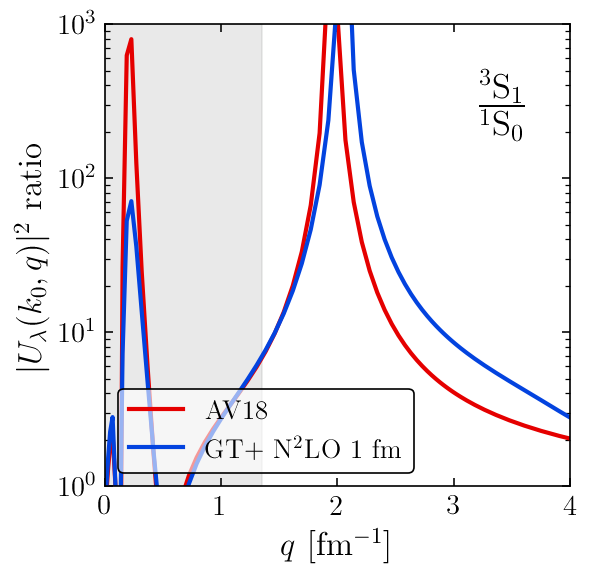

In [19]:
srg_transformation_ratio(k_0, kvnns, lamb, save=True)

## Deuteron bar chart

Percentage contributions from each channel to the matrix element of the momentum distribution in the deuteron with $q=2$, $3$, and $4$ fm$^{-1}$ for AV18 (left bar at each $\lambda$ value) and GT+ N$^2$LO (right bar) potentials.
We compare unevolved and SRG-evolved (both wave function and operator, so the net matrix element is unchanged) results where $\lambda=1.35$ fm$^{-1}$.

In [20]:
kvnns = (6, 222)
lamb = 1.35
q_values = np.array([2, 3, 4])
n = len(q_values)

labels = (r'$\infty$', r'$1.35$')
if n == 1:
    x_labels = labels
elif n == 2:
    x_labels = labels + labels
elif n == 3:
    x_labels = labels + labels + labels

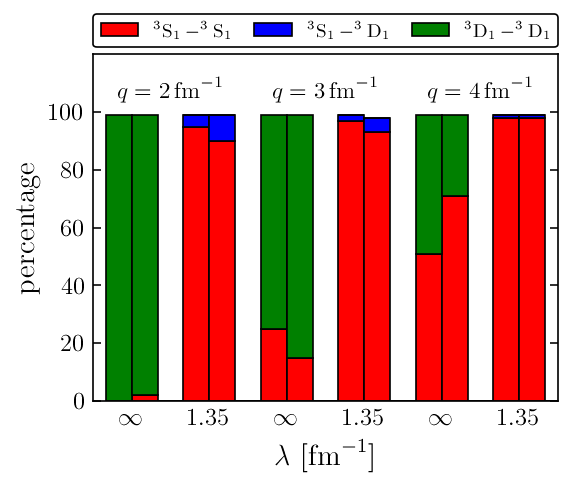

In [21]:
deuteron_percentage_bar_chart(kvnns, lamb, q_values, x_labels=x_labels,
        title=None)

## Deuteron momentum distribution

Contributions to the deuteron momentum distribution $n_\lambda^d(q)$ with AV18 and $\lambda=1.35$ fm$^{-1}$.
For reference, the unevolved deuteron momentum distribution is shown.
The normalization is $\frac{2}{\pi} \int_0^{\infty} dq\, q^2 n^d_{\lambda}(q)$ = 1.

In [22]:
kvnn = 6
lamb = 1.35

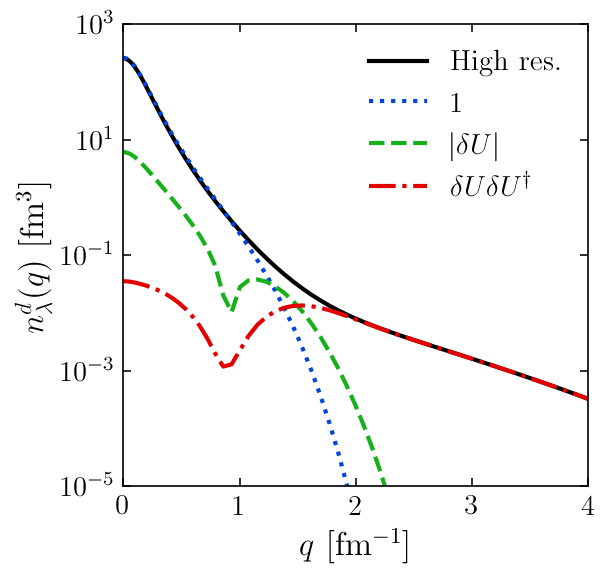

In [23]:
for i in range(1,5):
    deuteron_momentum_distribution_contributions(
        kvnn, lamb, number_of_curves=i, save=True
    )

## Factorization

Numerical tests of factorization of $\delta U \delta U^{\dagger}$ by plotting ratios of $\delta U \delta U^{\dagger}(k,q)$ in the $^{3}\rm{S}_1$ channel as a function of $q$ for fixed $k=k_0$ in the denominator and several values of $k_i$ in the numerator.
Plateaus in $q$ indicate factorization $\delta U(k,q) \approx F_{\rm{lo}}(k) F_{\rm{hi}}(q)$, which is expected for $q\gg\lambda$ (outside the shaded box) and $k < \lambda$.
We generate SRG transformations from AV18 evolved to $\lambda=1.35$ fm$^{-1}$, first with $k_0=0.1$ fm$^{-1}$.

In [24]:
k_i_values = (0.5, 1.0, 1.5, 3.0)
kvnn = 6
channel = '3S1'
lamb = 1.35

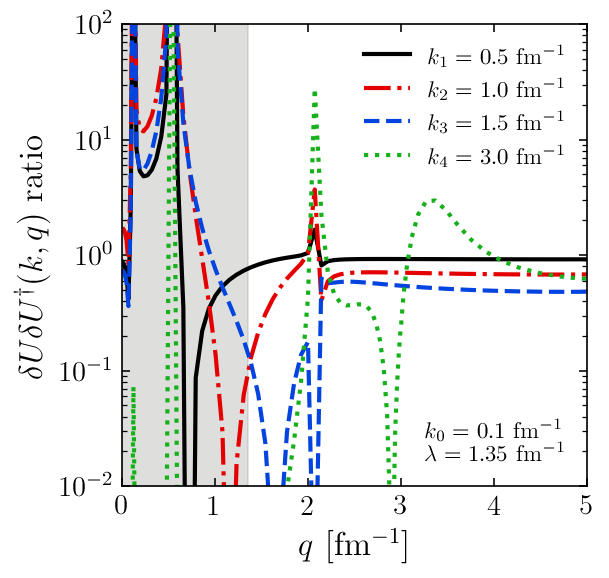

In [25]:
delU_factorization_ratios(0.1, k_i_values, kvnn, channel, lamb, save=True)

Same as the previous figure but with $k_0=0.2$ fm$^{-1}$.

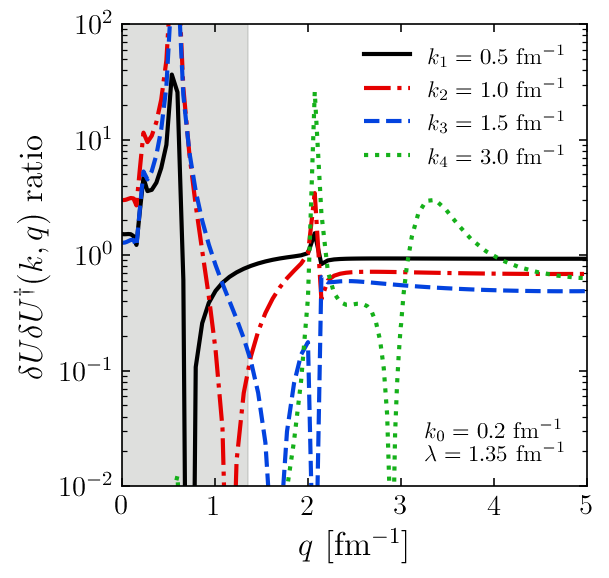

In [26]:
delU_factorization_ratios(0.2, k_i_values, kvnn, channel, lamb, save=True)

Same as the previous figure but with $k_0=0.4$ fm$^{-1}$.

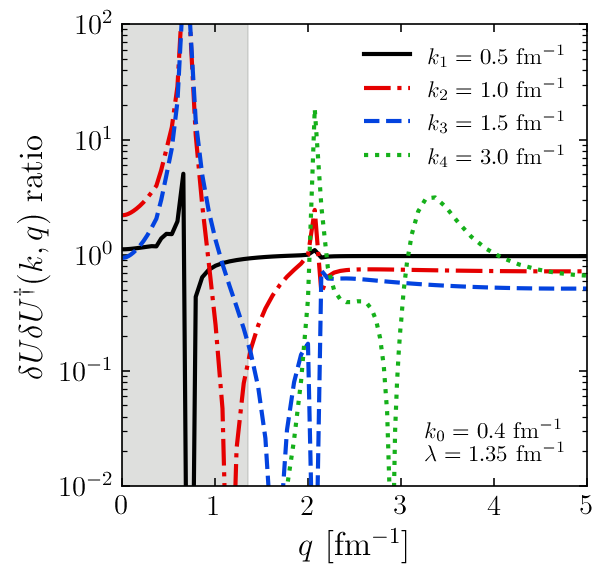

In [27]:
delU_factorization_ratios(0.4, k_i_values, kvnn, channel, lamb, save=True)

## Proton momentum distributions

Proton momentum distributions for $^{12}$C, $^{16}$O, and $^{40}$Ca calculated in the LDA.
We use AV18 to SRG-evolve the operator setting $\lambda=1.35$ fm$^{-1}$, and divide each distribution by the proton number $Z$.
The gray-shaded sections are where $q<\lambda$.
Black dots correspond to AV18 variational Monte Carlo calculations.

In [28]:
nuclei = (('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))
kvnn = 6

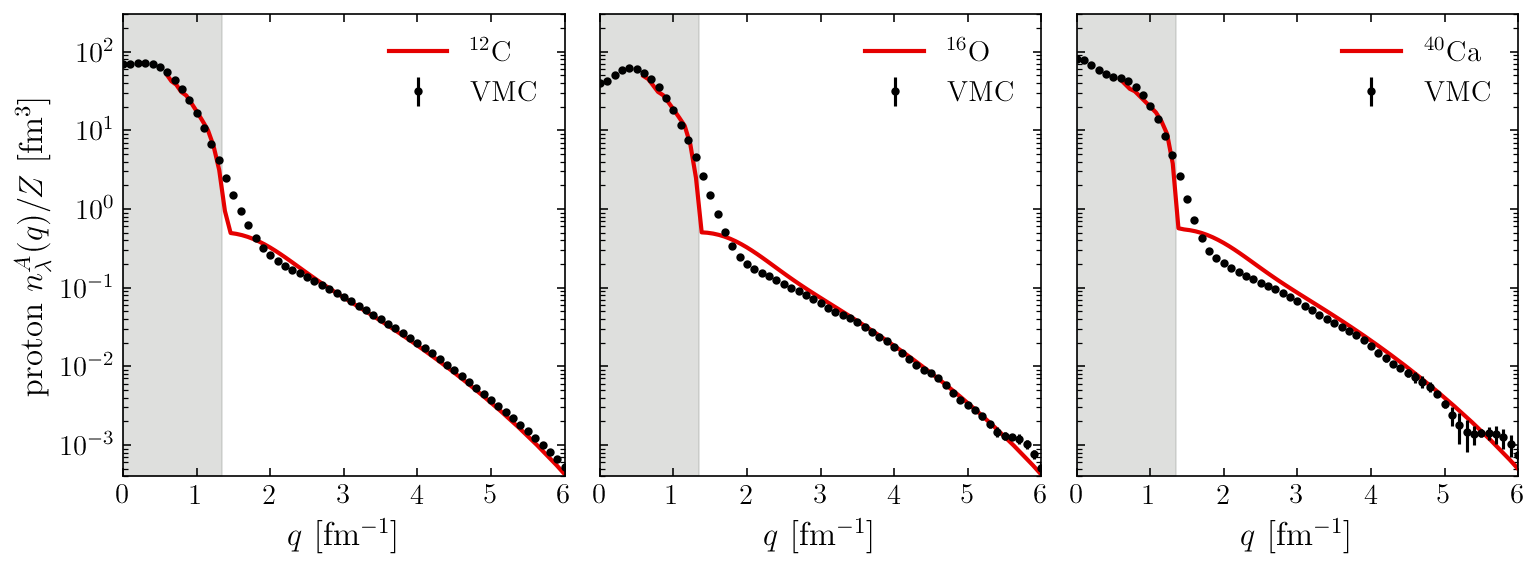

In [29]:
multiple_proton_momentum_distributions(nuclei, kvnn, save=True)

Comparison of the high-momentum tail in proton momentum distributions for various nuclei with the same inputs as above.

In [30]:
nuclei = (
    ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28),
    ('Fe56', 26, 30), ('Pb208', 82, 126)
)
kvnn = 6

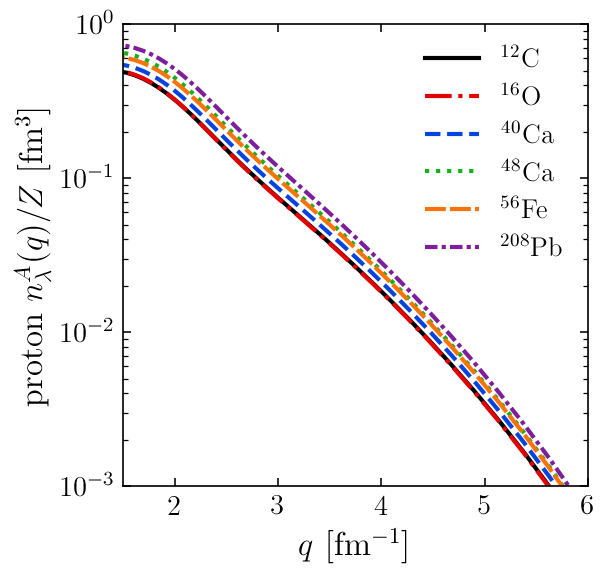

In [31]:
proton_momentum_distribution_tails(nuclei, kvnn, save=True)

Percentage contributions from S waves and selected P waves to proton momentum distributions for $q>2$ fm$^{-1}$.
We show $N_X/N$ with $N \sim \int_2^{\infty} dq\, q^2 n_{\lambda}^A(q)$, where $n_{\lambda}^A(q)$ is the proton distribution for nucleus $A$ with evolved operator at $\lambda = 1.35$ fm$^{-1}$ and $X$ denotes using only one partial wave.

In [32]:
partial_wave_contributions_table(nuclei, kvnn)


C12
----------
1S0: 15.4%
3S1: 79.0%
3P0: 1.0%
1P1: 0.8%
3P1: 3.8%

O16
----------
1S0: 15.4%
3S1: 79.2%
3P0: 1.0%
1P1: 0.8%
3P1: 3.6%

Ca40
----------
1S0: 15.3%
3S1: 78.9%
3P0: 1.0%
1P1: 0.9%
3P1: 3.9%

Ca48
----------
1S0: 13.5%
3S1: 81.3%
3P0: 0.9%
1P1: 0.9%
3P1: 3.4%

Fe56
----------
1S0: 14.5%
3S1: 79.8%
3P0: 1.0%
1P1: 0.9%
3P1: 3.8%

Pb208
----------
1S0: 12.8%
3S1: 82.2%
3P0: 0.9%
1P1: 1.0%
3P1: 3.2%


## Pair momentum distribution ratios

In [33]:
nuclei = (
    ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28),
    ('Fe56', 26, 30), ('Pb208', 82, 126)
)
kvnn = 6

Ratios of $pp+pn$ to $nn+np$ distributions for various nuclei calculated in the LDA with the leading two-body truncation of the pair distribution operator evaluated at $Q=0$.
We use AV18 and set $\lambda=1.35$ fm$^{-1}$.

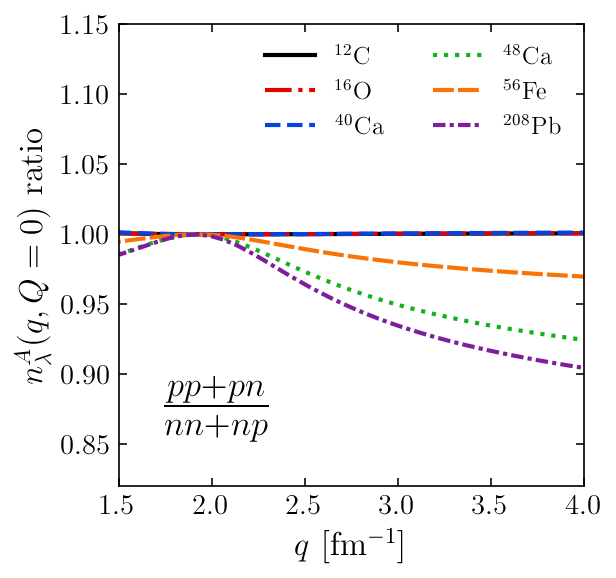

In [34]:
proton_over_neutron_pmd_ratios(nuclei, kvnn, save=True)

Same as the previous figure but with the ratio being $pp$ to $pn+np$.

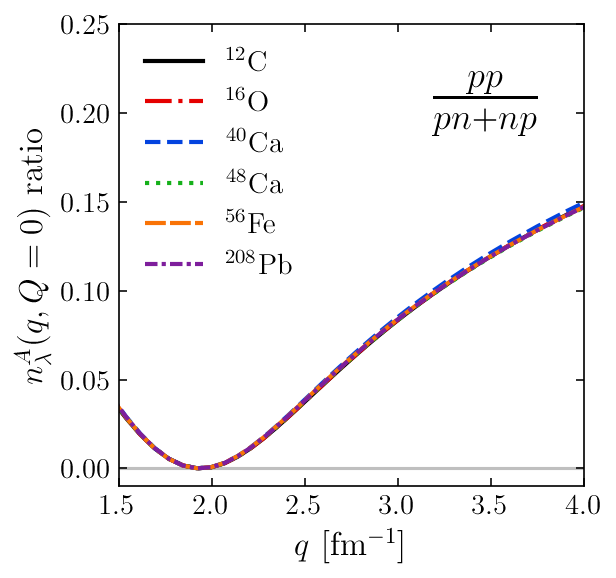

In [35]:
pp_over_pn_pmd_ratios(nuclei, kvnn, save=True)

## SRC scaling factors $a_2$

SRC scaling factors $a_2$ calculated using AV18 and $\lambda=1.35$ fm$^{-1}$, comparing to experimental data.
We use both SLy4 and Gogny densities in the LDA calculation.

In [36]:
kvnn = 6
lamb = 1.35

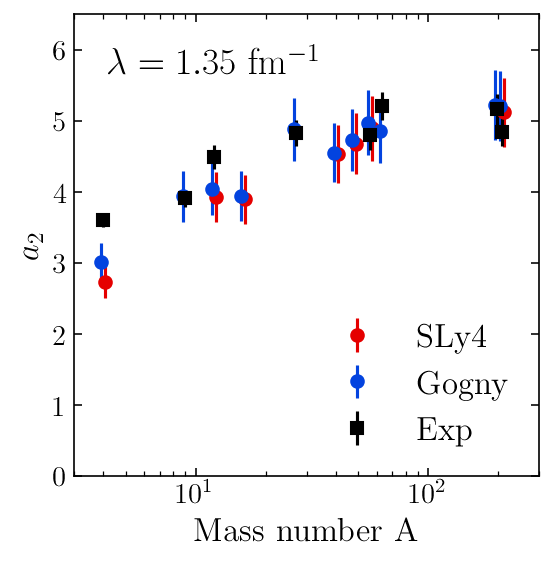

In [37]:
src_scaling_factors(kvnn, lamb, save=True)